<a href="https://colab.research.google.com/github/trichyravis/Heston_Volatility_Model/blob/main/15th_Feb_2026_Heston_Volatility_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

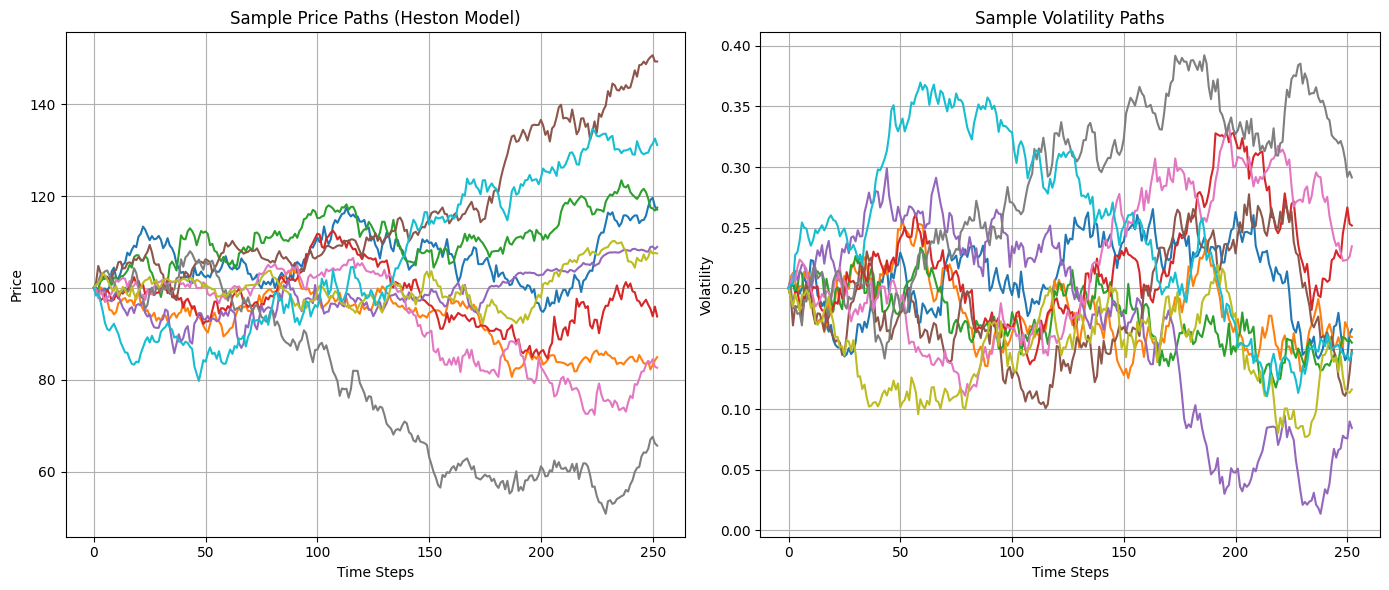

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def heston_simulation(S0, v0, mu, kappa, theta, sigma_v, rho, T, steps, paths):
    """
    Simulate paths using Heston stochastic volatility model

    Parameters:
    S0: Initial stock price
    v0: Initial variance
    mu: Drift
    kappa: Mean reversion speed
    theta: Long-term variance
    sigma_v: Volatility of volatility
    rho: Correlation between price and variance
    T: Time horizon
    steps: Number of time steps
    paths: Number of simulation paths
    """
    dt = T / steps

    # Initialize arrays
    S = np.zeros((steps + 1, paths))
    v = np.zeros((steps + 1, paths))
    S[0] = S0
    v[0] = v0

    # Generate correlated random numbers
    for i in range(1, steps + 1):
        Z1 = np.random.standard_normal(paths)
        Z2 = np.random.standard_normal(paths)

        # Correlate the Brownian motions
        W_S = Z1
        W_v = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        # Euler discretization with full truncation
        v[i] = np.maximum(v[i-1] + kappa * (theta - v[i-1]) * dt +
                          sigma_v * np.sqrt(np.maximum(v[i-1], 0)) * np.sqrt(dt) * W_v, 0)

        S[i] = S[i-1] * np.exp((mu - 0.5 * v[i-1]) * dt +
                                np.sqrt(np.maximum(v[i-1], 0)) * np.sqrt(dt) * W_S)

    return S, v

# Example parameters
S0 = 100      # Initial price
v0 = 0.04     # Initial variance (20% vol)
mu = 0.05     # Drift
kappa = 2.0   # Mean reversion speed
theta = 0.04  # Long-term variance
sigma_v = 0.3 # Vol of vol
rho = -0.7    # Correlation
T = 1.0       # 1 year
steps = 252   # Daily steps
paths = 1000  # Number of paths

# Simulate
S, v = heston_simulation(S0, v0, mu, kappa, theta, sigma_v, rho, T, steps, paths)

# Visualize
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(S[:, :10])
plt.title('Sample Price Paths (Heston Model)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.sqrt(v[:, :10]))
plt.title('Sample Volatility Paths')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.grid(True)

plt.tight_layout()
plt.show()

In [1]:
"""
================================================================================
HESTON VOLATILITY MODEL - COMPLETE PYTHON IMPLEMENTATION
================================================================================
Prof. V. Ravichandran
The Mountain Path - World of Finance

This module provides a comprehensive implementation of the Heston stochastic
volatility model including:
- European option pricing via Fourier inversion
- Model calibration to market prices
- Monte Carlo simulation (Euler and QE schemes)
- Greeks calculation
- Risk metrics (VaR, CVaR)
- Visualization tools

Requirements:
    numpy, scipy, matplotlib, pandas
================================================================================
"""

import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Optional
import warnings

warnings.filterwarnings('ignore')


# =============================================================================
# PART 1: HESTON CHARACTERISTIC FUNCTION AND OPTION PRICING
# =============================================================================

class HestonModel:
    """
    Heston Stochastic Volatility Model

    Model dynamics:
        dS(t) = r*S(t)*dt + sqrt(V(t))*S(t)*dW1(t)
        dV(t) = kappa*(theta - V(t))*dt + sigma_v*sqrt(V(t))*dW2(t)
        dW1(t)*dW2(t) = rho*dt

    Parameters:
    -----------
    S0 : float
        Initial stock price
    V0 : float
        Initial variance
    kappa : float
        Mean reversion speed
    theta : float
        Long-run variance
    sigma_v : float
        Volatility of volatility
    rho : float
        Correlation between price and variance
    r : float
        Risk-free rate
    q : float, optional
        Dividend yield (default 0)
    """

    def __init__(self, S0: float, V0: float, kappa: float, theta: float,
                 sigma_v: float, rho: float, r: float, q: float = 0.0):
        self.S0 = S0
        self.V0 = V0
        self.kappa = kappa
        self.theta = theta
        self.sigma_v = sigma_v
        self.rho = rho
        self.r = r
        self.q = q

        # Validate parameters
        self._validate_parameters()

    def _validate_parameters(self):
        """Validate Heston model parameters"""
        if self.S0 <= 0:
            raise ValueError("Initial stock price must be positive")
        if self.V0 <= 0:
            raise ValueError("Initial variance must be positive")
        if self.kappa <= 0:
            raise ValueError("Mean reversion speed must be positive")
        if self.theta <= 0:
            raise ValueError("Long-run variance must be positive")
        if self.sigma_v <= 0:
            raise ValueError("Volatility of volatility must be positive")
        if self.rho <= -1 or self.rho >= 1:
            raise ValueError("Correlation must be in (-1, 1)")

        # Check Feller condition
        feller = 2 * self.kappa * self.theta
        if feller < self.sigma_v**2:
            warnings.warn(
                f"Feller condition violated: 2*kappa*theta ({feller:.4f}) < "
                f"sigma_v^2 ({self.sigma_v**2:.4f}). Variance can reach zero."
            )

    def characteristic_function(self, u: complex, T: float, j: int) -> complex:
        """
        Heston characteristic function for probability calculation

        Parameters:
        -----------
        u : complex
            Frequency parameter
        T : float
            Time to maturity
        j : int
            1 or 2 (determines which probability measure)

        Returns:
        --------
        complex
            Characteristic function value
        """
        # Define measure-specific parameters
        if j == 1:
            u_j = 0.5
            b_j = self.kappa - self.rho * self.sigma_v
        else:
            u_j = -0.5
            b_j = self.kappa

        # Complex number calculations
        d = np.sqrt(
            (self.rho * self.sigma_v * u * 1j - b_j)**2 -
            self.sigma_v**2 * (2 * u_j * u * 1j - u**2)
        )

        g = (b_j - self.rho * self.sigma_v * u * 1j + d) / \
            (b_j - self.rho * self.sigma_v * u * 1j - d)

        # C and D functions
        C = (self.r - self.q) * u * 1j * T + \
            (self.kappa * self.theta / self.sigma_v**2) * (
                (b_j - self.rho * self.sigma_v * u * 1j + d) * T -
                2 * np.log((1 - g * np.exp(d * T)) / (1 - g))
            )

        D = ((b_j - self.rho * self.sigma_v * u * 1j + d) / self.sigma_v**2) * \
            ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))

        # Characteristic function
        phi = np.exp(C + D * self.V0 + 1j * u * np.log(self.S0))

        return phi

    def _probability(self, K: float, T: float, j: int) -> float:
        """
        Compute probability Pj via Fourier inversion

        Parameters:
        -----------
        K : float
            Strike price
        T : float
            Time to maturity
        j : int
            1 or 2 (probability measure)

        Returns:
        --------
        float
            Probability value
        """
        def integrand(u):
            phi = self.characteristic_function(u, T, j)
            numerator = np.exp(-1j * u * np.log(K)) * phi
            denominator = 1j * u
            return np.real(numerator / denominator)

        # Numerical integration
        integral, _ = quad(integrand, 0, 100, limit=100)
        probability = 0.5 + (1 / np.pi) * integral

        return probability

    def call_price(self, K: float, T: float) -> float:
        """
        Heston model European call option price

        Parameters:
        -----------
        K : float
            Strike price
        T : float
            Time to maturity

        Returns:
        --------
        float
            Call option price
        """
        P1 = self._probability(K, T, j=1)
        P2 = self._probability(K, T, j=2)

        call_price = self.S0 * np.exp(-self.q * T) * P1 - \
                     K * np.exp(-self.r * T) * P2

        return call_price

    def put_price(self, K: float, T: float) -> float:
        """
        Heston model European put option price (via put-call parity)

        Parameters:
        -----------
        K : float
            Strike price
        T : float
            Time to maturity

        Returns:
        --------
        float
            Put option price
        """
        call = self.call_price(K, T)
        put = call - self.S0 * np.exp(-self.q * T) + K * np.exp(-self.r * T)
        return put

    def __repr__(self):
        return (f"HestonModel(S0={self.S0}, V0={self.V0:.4f}, "
                f"kappa={self.kappa:.4f}, theta={self.theta:.4f}, "
                f"sigma_v={self.sigma_v:.4f}, rho={self.rho:.4f}, "
                f"r={self.r:.4f})")


# =============================================================================
# PART 2: MODEL CALIBRATION
# =============================================================================

class HestonCalibrator:
    """
    Calibrate Heston model to market option prices
    """

    def __init__(self, S0: float, r: float, q: float = 0.0):
        self.S0 = S0
        self.r = r
        self.q = q

    def objective_function(self, params: np.ndarray,
                          market_data: List[Dict]) -> float:
        """
        Objective function for calibration

        Parameters:
        -----------
        params : array
            [kappa, theta, sigma_v, rho, V0]
        market_data : list of dicts
            Each dict contains 'strike', 'maturity', 'market_price', 'weight'

        Returns:
        --------
        float
            Weighted sum of squared errors
        """
        kappa, theta, sigma_v, rho, V0 = params

        # Parameter constraints
        if kappa <= 0 or theta <= 0 or sigma_v <= 0 or V0 <= 0:
            return 1e10
        if rho <= -1 or rho >= 1:
            return 1e10
        # Soft Feller condition
        if 2 * kappa * theta < 0.5 * sigma_v**2:
            return 1e10

        total_error = 0

        try:
            # Create model with current parameters
            model = HestonModel(self.S0, V0, kappa, theta, sigma_v,
                               rho, self.r, self.q)

            for data in market_data:
                K = data['strike']
                T = data['maturity']
                market_price = data['market_price']
                weight = data.get('weight', 1.0)
                option_type = data.get('type', 'call')

                # Compute model price
                if option_type.lower() == 'call':
                    model_price = model.call_price(K, T)
                else:
                    model_price = model.put_price(K, T)

                # Squared error
                error = (model_price - market_price)**2
                total_error += weight * error

        except Exception as e:
            return 1e10

        return total_error

    def calibrate(self, market_data: List[Dict],
                 initial_guess: Optional[np.ndarray] = None,
                 bounds: Optional[List[Tuple]] = None) -> Dict:
        """
        Calibrate Heston model to market prices

        Parameters:
        -----------
        market_data : list of dicts
            Market option data
        initial_guess : array, optional
            Starting values [kappa, theta, sigma_v, rho, V0]
        bounds : list of tuples, optional
            Parameter bounds

        Returns:
        --------
        dict
            Calibrated parameters and diagnostics
        """
        if initial_guess is None:
            # Default starting values
            initial_guess = np.array([2.0, 0.04, 0.3, -0.5, 0.04])

        if bounds is None:
            # Default bounds
            bounds = [
                (0.1, 10.0),     # kappa
                (0.01, 0.5),     # theta
                (0.05, 2.0),     # sigma_v
                (-0.99, -0.01),  # rho (negative for equities)
                (0.01, 0.5)      # V0
            ]

        # Optimization
        result = minimize(
            self.objective_function,
            initial_guess,
            args=(market_data,),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000, 'ftol': 1e-8}
        )

        # Extract calibrated parameters
        kappa, theta, sigma_v, rho, V0 = result.x

        # Calculate fit quality
        model = HestonModel(self.S0, V0, kappa, theta, sigma_v,
                           rho, self.r, self.q)

        errors = []
        for data in market_data:
            K = data['strike']
            T = data['maturity']
            market_price = data['market_price']
            option_type = data.get('type', 'call')

            if option_type.lower() == 'call':
                model_price = model.call_price(K, T)
            else:
                model_price = model.put_price(K, T)

            errors.append(model_price - market_price)

        rmse = np.sqrt(np.mean(np.array(errors)**2))
        max_error = np.max(np.abs(errors))

        return {
            'kappa': kappa,
            'theta': theta,
            'sigma_v': sigma_v,
            'rho': rho,
            'V0': V0,
            'success': result.success,
            'objective_value': result.fun,
            'rmse': rmse,
            'max_error': max_error,
            'errors': errors,
            'model': model
        }


# =============================================================================
# PART 3: MONTE CARLO SIMULATION
# =============================================================================

class HestonMonteCarlo:
    """
    Monte Carlo simulation for Heston model
    """

    def __init__(self, model: HestonModel):
        self.model = model

    def simulate_euler(self, T: float, n_steps: int, n_paths: int,
                      random_seed: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Simulate Heston paths using Euler-Maruyama scheme

        Parameters:
        -----------
        T : float
            Time horizon
        n_steps : int
            Number of time steps
        n_paths : int
            Number of simulation paths
        random_seed : int, optional
            Random seed for reproducibility

        Returns:
        --------
        tuple
            (S_paths, V_paths) arrays of shape (n_paths, n_steps+1)
        """
        if random_seed is not None:
            np.random.seed(random_seed)

        dt = T / n_steps

        # Initialize arrays
        S = np.zeros((n_paths, n_steps + 1))
        V = np.zeros((n_paths, n_steps + 1))
        S[:, 0] = self.model.S0
        V[:, 0] = self.model.V0

        for i in range(n_steps):
            # Generate correlated random variables
            Z1 = np.random.standard_normal(n_paths)
            Z2_indep = np.random.standard_normal(n_paths)
            Z2 = self.model.rho * Z1 + \
                 np.sqrt(1 - self.model.rho**2) * Z2_indep

            # Variance process (with truncation)
            V[:, i+1] = np.maximum(
                V[:, i] + self.model.kappa * (self.model.theta - V[:, i]) * dt +
                self.model.sigma_v * np.sqrt(V[:, i]) * np.sqrt(dt) * Z2,
                0
            )

            # Asset price process (log-normal)
            S[:, i+1] = S[:, i] * np.exp(
                (self.model.r - self.model.q - 0.5 * V[:, i]) * dt +
                np.sqrt(V[:, i]) * np.sqrt(dt) * Z1
            )

        return S, V

    def simulate_qe(self, T: float, n_steps: int, n_paths: int,
                   psi_c: float = 1.5, random_seed: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Simulate Heston paths using Quadratic-Exponential (QE) scheme

        Parameters:
        -----------
        T : float
            Time horizon
        n_steps : int
            Number of time steps
        n_paths : int
            Number of simulation paths
        psi_c : float
            Critical threshold (default 1.5)
        random_seed : int, optional
            Random seed

        Returns:
        --------
        tuple
            (S_paths, V_paths) arrays of shape (n_paths, n_steps+1)
        """
        if random_seed is not None:
            np.random.seed(random_seed)

        dt = T / n_steps

        S = np.zeros((n_paths, n_steps + 1))
        V = np.zeros((n_paths, n_steps + 1))
        S[:, 0] = self.model.S0
        V[:, 0] = self.model.V0

        for i in range(n_steps):
            # Generate random variables
            Z_v = np.random.standard_normal(n_paths)
            Z_s = np.random.standard_normal(n_paths)
            U = np.random.uniform(0, 1, n_paths)

            # Variance process with QE scheme
            m = self.model.theta + \
                (V[:, i] - self.model.theta) * np.exp(-self.model.kappa * dt)

            s2 = (V[:, i] * self.model.sigma_v**2 *
                  np.exp(-self.model.kappa * dt) / self.model.kappa *
                  (1 - np.exp(-self.model.kappa * dt)) +
                  self.model.theta * self.model.sigma_v**2 / (2 * self.model.kappa) *
                  (1 - np.exp(-self.model.kappa * dt))**2)

            psi = s2 / m**2

            # QE scheme branching
            V_next = np.zeros(n_paths)

            # Case 1: psi <= psi_c (quadratic)
            mask1 = psi <= psi_c
            if np.any(mask1):
                b2 = 2 / psi[mask1] - 1 + \
                     np.sqrt(2 / psi[mask1]) * np.sqrt(2 / psi[mask1] - 1)
                a = m[mask1] / (1 + b2)
                V_next[mask1] = a * (np.sqrt(b2) + Z_v[mask1])**2

            # Case 2: psi > psi_c (exponential)
            mask2 = ~mask1
            if np.any(mask2):
                p = (psi[mask2] - 1) / (psi[mask2] + 1)
                beta = (1 - p) / m[mask2]

                V_next[mask2] = np.where(
                    U[mask2] <= p,
                    0,
                    np.log((1 - p) / (1 - U[mask2])) / beta
                )

            V[:, i+1] = V_next

            # Asset price with exact solution conditional on V
            K0 = -self.model.rho * self.model.kappa * self.model.theta / \
                 self.model.sigma_v * dt
            K1 = 0.5 * dt * (self.model.kappa * self.model.rho /
                            self.model.sigma_v - 0.5) - \
                 self.model.rho / self.model.sigma_v
            K2 = 0.5 * dt * (self.model.kappa * self.model.rho /
                            self.model.sigma_v - 0.5) + \
                 self.model.rho / self.model.sigma_v
            K3 = 0.5 * dt * (1 - self.model.rho**2)

            S[:, i+1] = S[:, i] * np.exp(
                (self.model.r - self.model.q) * dt + K0 +
                K1 * V[:, i] + K2 * V[:, i+1] +
                np.sqrt(K3 * (V[:, i] + V[:, i+1])) * Z_s
            )

        return S, V

    def price_european_option(self, K: float, T: float, option_type: str,
                            n_steps: int = 252, n_paths: int = 10000,
                            scheme: str = 'qe') -> Dict:
        """
        Price European option via Monte Carlo

        Parameters:
        -----------
        K : float
            Strike price
        T : float
            Time to maturity
        option_type : str
            'call' or 'put'
        n_steps : int
            Number of time steps
        n_paths : int
            Number of simulation paths
        scheme : str
            'euler' or 'qe'

        Returns:
        --------
        dict
            Price, standard error, and confidence interval
        """
        # Simulate paths
        if scheme.lower() == 'euler':
            S_paths, _ = self.simulate_euler(T, n_steps, n_paths)
        else:
            S_paths, _ = self.simulate_qe(T, n_steps, n_paths)

        # Terminal prices
        S_T = S_paths[:, -1]

        # Payoffs
        if option_type.lower() == 'call':
            payoffs = np.maximum(S_T - K, 0)
        else:
            payoffs = np.maximum(K - S_T, 0)

        # Discounted expected payoff
        price = np.exp(-self.model.r * T) * np.mean(payoffs)
        std_error = np.exp(-self.model.r * T) * np.std(payoffs) / np.sqrt(n_paths)

        return {
            'price': price,
            'std_error': std_error,
            'ci_lower': price - 1.96 * std_error,
            'ci_upper': price + 1.96 * std_error
        }


# =============================================================================
# PART 4: GREEKS CALCULATION
# =============================================================================

class HestonGreeks:
    """
    Calculate option Greeks for Heston model
    """

    def __init__(self, model: HestonModel):
        self.model = model

    def calculate_greeks(self, K: float, T: float,
                        bump_size: float = 0.01) -> Dict:
        """
        Compute option Greeks using finite differences

        Parameters:
        -----------
        K : float
            Strike price
        T : float
            Time to maturity
        bump_size : float
            Size of parameter bump for finite differences

        Returns:
        --------
        dict
            Dictionary of Greeks
        """
        # Base price
        base_price = self.model.call_price(K, T)

        # Delta: sensitivity to spot price
        model_up_S = HestonModel(
            self.model.S0 + bump_size, self.model.V0,
            self.model.kappa, self.model.theta, self.model.sigma_v,
            self.model.rho, self.model.r, self.model.q
        )
        model_down_S = HestonModel(
            self.model.S0 - bump_size, self.model.V0,
            self.model.kappa, self.model.theta, self.model.sigma_v,
            self.model.rho, self.model.r, self.model.q
        )
        price_up_S = model_up_S.call_price(K, T)
        price_down_S = model_down_S.call_price(K, T)
        delta = (price_up_S - price_down_S) / (2 * bump_size)

        # Gamma: convexity w.r.t. spot
        gamma = (price_up_S - 2 * base_price + price_down_S) / (bump_size**2)

        # Vega: sensitivity to variance
        model_up_V = HestonModel(
            self.model.S0, self.model.V0 + bump_size,
            self.model.kappa, self.model.theta, self.model.sigma_v,
            self.model.rho, self.model.r, self.model.q
        )
        vega = model_up_V.call_price(K, T) - base_price

        # Theta: time decay (1 day)
        theta_price = self.model.call_price(K, max(T - 1/365, 0.01))
        theta = theta_price - base_price

        # Rho: sensitivity to interest rate
        model_up_r = HestonModel(
            self.model.S0, self.model.V0,
            self.model.kappa, self.model.theta, self.model.sigma_v,
            self.model.rho, self.model.r + bump_size, self.model.q
        )
        rho_greek = model_up_r.call_price(K, T) - base_price

        return {
            'price': base_price,
            'delta': delta,
            'gamma': gamma,
            'vega': vega,
            'theta': theta,
            'rho': rho_greek
        }


# =============================================================================
# PART 5: RISK METRICS
# =============================================================================

class HestonRiskMetrics:
    """
    Calculate risk metrics using Heston model
    """

    def __init__(self, model: HestonModel):
        self.model = model
        self.mc = HestonMonteCarlo(model)

    def calculate_var_cvar(self, T: float, n_paths: int = 50000,
                          confidence: float = 0.95,
                          scheme: str = 'qe') -> Dict:
        """
        Compute VaR and CVaR

        Parameters:
        -----------
        T : float
            Time horizon
        n_paths : int
            Number of simulation paths
        confidence : float
            Confidence level
        scheme : str
            Simulation scheme

        Returns:
        --------
        dict
            VaR, CVaR, and return statistics
        """
        # Simulate paths
        if scheme.lower() == 'euler':
            S_paths, V_paths = self.mc.simulate_euler(T, 252, n_paths)
        else:
            S_paths, V_paths = self.mc.simulate_qe(T, 252, n_paths)

        # Calculate returns
        terminal_prices = S_paths[:, -1]
        returns = (terminal_prices - self.model.S0) / self.model.S0

        # VaR calculation
        var = -np.percentile(returns, (1 - confidence) * 100)

        # CVaR (Expected Shortfall)
        losses = -returns
        cvar = losses[losses >= var].mean()

        # Additional statistics
        from scipy.stats import skew, kurtosis

        return {
            'VaR': var,
            'CVaR': cvar,
            'mean_return': returns.mean(),
            'volatility': returns.std(),
            'skewness': skew(returns),
            'kurtosis': kurtosis(returns)
        }


# =============================================================================
# PART 6: VISUALIZATION TOOLS
# =============================================================================

class HestonVisualizer:
    """
    Visualization tools for Heston model
    """

    @staticmethod
    def plot_volatility_smile(model: HestonModel, T: float,
                             strikes: Optional[np.ndarray] = None):
        """
        Plot implied volatility smile
        """
        if strikes is None:
            strikes = np.linspace(0.8 * model.S0, 1.2 * model.S0, 20)

        # Calculate call prices
        prices = [model.call_price(K, T) for K in strikes]

        # Calculate implied volatilities (simplified - using Black-Scholes inversion)
        from scipy.stats import norm

        def bs_call(S, K, T, r, sigma):
            d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
            d2 = d1 - sigma*np.sqrt(T)
            return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

        def implied_vol(price, S, K, T, r):
            from scipy.optimize import brentq
            try:
                return brentq(lambda sigma: bs_call(S, K, T, r, sigma) - price,
                            0.01, 2.0)
            except:
                return np.nan

        ivs = [implied_vol(p, model.S0, K, T, model.r)
               for p, K in zip(prices, strikes)]

        plt.figure(figsize=(10, 6))
        plt.plot(strikes / model.S0, np.array(ivs) * 100, 'b-o', linewidth=2)
        plt.axvline(1.0, color='r', linestyle='--', alpha=0.5, label='ATM')
        plt.xlabel('Strike / Spot', fontsize=12)
        plt.ylabel('Implied Volatility (%)', fontsize=12)
        plt.title(f'Heston Model Volatility Smile (T={T:.2f} years)', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        return plt.gcf()

    @staticmethod
    def plot_simulated_paths(S_paths: np.ndarray, V_paths: np.ndarray,
                           n_paths_display: int = 10):
        """
        Plot simulated price and variance paths
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Price paths
        ax1.plot(S_paths[:n_paths_display, :].T, alpha=0.6)
        ax1.set_xlabel('Time Steps', fontsize=11)
        ax1.set_ylabel('Stock Price', fontsize=11)
        ax1.set_title('Simulated Asset Price Paths', fontsize=13)
        ax1.grid(True, alpha=0.3)

        # Variance paths
        ax2.plot(V_paths[:n_paths_display, :].T, alpha=0.6)
        ax2.set_xlabel('Time Steps', fontsize=11)
        ax2.set_ylabel('Variance', fontsize=11)
        ax2.set_title('Simulated Variance Paths', fontsize=13)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    @staticmethod
    def plot_calibration_fit(market_data: List[Dict],
                           calibrated_model: HestonModel):
        """
        Plot calibration fit
        """
        strikes = [d['strike'] for d in market_data]
        market_prices = [d['market_price'] for d in market_data]
        maturities = [d['maturity'] for d in market_data]

        model_prices = []
        for data in market_data:
            K = data['strike']
            T = data['maturity']
            option_type = data.get('type', 'call')
            if option_type.lower() == 'call':
                model_prices.append(calibrated_model.call_price(K, T))
            else:
                model_prices.append(calibrated_model.put_price(K, T))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Price comparison
        ax1.scatter(market_prices, model_prices, alpha=0.6, s=50)
        min_p = min(min(market_prices), min(model_prices))
        max_p = max(max(market_prices), max(model_prices))
        ax1.plot([min_p, max_p], [min_p, max_p], 'r--', linewidth=2)
        ax1.set_xlabel('Market Prices', fontsize=11)
        ax1.set_ylabel('Model Prices', fontsize=11)
        ax1.set_title('Price Fit', fontsize=13)
        ax1.grid(True, alpha=0.3)

        # Errors
        errors = np.array(model_prices) - np.array(market_prices)
        ax2.scatter(strikes, errors, alpha=0.6, s=50)
        ax2.axhline(0, color='r', linestyle='--', linewidth=2)
        ax2.set_xlabel('Strike Price', fontsize=11)
        ax2.set_ylabel('Pricing Error', fontsize=11)
        ax2.set_title('Calibration Errors', fontsize=13)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig


# =============================================================================
# PART 7: EXAMPLE USAGE AND TESTING
# =============================================================================

def example_basic_pricing():
    """Example: Basic option pricing"""
    print("=" * 80)
    print("EXAMPLE 1: BASIC HESTON OPTION PRICING")
    print("=" * 80)

    # Create Heston model
    model = HestonModel(
        S0=100,      # Current stock price
        V0=0.04,     # Initial variance (20% vol)
        kappa=2.0,   # Mean reversion speed
        theta=0.04,  # Long-run variance
        sigma_v=0.3, # Volatility of volatility
        rho=-0.7,    # Correlation
        r=0.05       # Risk-free rate
    )

    print(model)
    print()

    # Price at-the-money call
    K = 100
    T = 1.0
    call_price = model.call_price(K, T)
    put_price = model.put_price(K, T)

    print(f"ATM Call Price (K={K}, T={T}): ${call_price:.4f}")
    print(f"ATM Put Price (K={K}, T={T}): ${put_price:.4f}")
    print()

    # Greeks
    greeks_calc = HestonGreeks(model)
    greeks = greeks_calc.calculate_greeks(K, T)

    print("Option Greeks:")
    for greek, value in greeks.items():
        print(f"  {greek.capitalize()}: {value:.4f}")
    print()


def example_calibration():
    """Example: Model calibration"""
    print("=" * 80)
    print("EXAMPLE 2: HESTON MODEL CALIBRATION")
    print("=" * 80)

    # Simulated market data
    S0 = 100
    r = 0.05

    market_data = [
        {'strike': 95, 'maturity': 0.5, 'market_price': 8.50, 'type': 'call'},
        {'strike': 100, 'maturity': 0.5, 'market_price': 5.20, 'type': 'call'},
        {'strike': 105, 'maturity': 0.5, 'market_price': 2.80, 'type': 'call'},
        {'strike': 95, 'maturity': 1.0, 'market_price': 11.20, 'type': 'call'},
        {'strike': 100, 'maturity': 1.0, 'market_price': 8.10, 'type': 'call'},
        {'strike': 105, 'maturity': 1.0, 'market_price': 5.50, 'type': 'call'},
    ]

    # Calibrate
    calibrator = HestonCalibrator(S0, r)
    result = calibrator.calibrate(market_data)

    print("Calibration Results:")
    print(f"  kappa:    {result['kappa']:.4f}")
    print(f"  theta:    {result['theta']:.4f}")
    print(f"  sigma_v:  {result['sigma_v']:.4f}")
    print(f"  rho:      {result['rho']:.4f}")
    print(f"  V0:       {result['V0']:.4f}")
    print()
    print(f"  RMSE:     ${result['rmse']:.4f}")
    print(f"  Max Error: ${result['max_error']:.4f}")
    print(f"  Success:  {result['success']}")
    print()


def example_monte_carlo():
    """Example: Monte Carlo simulation"""
    print("=" * 80)
    print("EXAMPLE 3: MONTE CARLO SIMULATION")
    print("=" * 80)

    # Create model
    model = HestonModel(
        S0=100, V0=0.04, kappa=2.0, theta=0.04,
        sigma_v=0.3, rho=-0.7, r=0.05
    )

    mc = HestonMonteCarlo(model)

    # Price option via Monte Carlo
    K = 100
    T = 1.0

    print("Pricing ATM Call Option via Monte Carlo:")
    result = mc.price_european_option(K, T, 'call', n_paths=50000, scheme='qe')

    print(f"  Price:      ${result['price']:.4f}")
    print(f"  Std Error:  ${result['std_error']:.4f}")
    print(f"  95% CI:     [${result['ci_lower']:.4f}, ${result['ci_upper']:.4f}]")
    print()

    # Compare with closed-form
    analytical = model.call_price(K, T)
    print(f"  Analytical: ${analytical:.4f}")
    print(f"  MC Error:   ${abs(result['price'] - analytical):.4f}")
    print()


def example_risk_metrics():
    """Example: Risk metrics calculation"""
    print("=" * 80)
    print("EXAMPLE 4: RISK METRICS (VaR & CVaR)")
    print("=" * 80)

    # Create model
    model = HestonModel(
        S0=100, V0=0.04, kappa=2.0, theta=0.04,
        sigma_v=0.3, rho=-0.7, r=0.05
    )

    risk = HestonRiskMetrics(model)

    # Calculate VaR and CVaR
    metrics = risk.calculate_var_cvar(T=1.0, n_paths=50000, confidence=0.95)

    print("Risk Metrics (1-year horizon, 95% confidence):")
    print(f"  VaR:        {metrics['VaR']*100:.2f}%")
    print(f"  CVaR:       {metrics['CVaR']*100:.2f}%")
    print(f"  Mean Return: {metrics['mean_return']*100:.2f}%")
    print(f"  Volatility:  {metrics['volatility']*100:.2f}%")
    print(f"  Skewness:    {metrics['skewness']:.4f}")
    print(f"  Kurtosis:    {metrics['kurtosis']:.4f}")
    print()


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("\n")
    print("╔" + "═" * 78 + "╗")
    print("║" + " " * 15 + "HESTON VOLATILITY MODEL - COMPLETE IMPLEMENTATION" + " " * 14 + "║")
    print("║" + " " * 24 + "Prof. V. Ravichandran" + " " * 33 + "║")
    print("║" + " " * 19 + "The Mountain Path - World of Finance" + " " * 22 + "║")
    print("╚" + "═" * 78 + "╝")
    print("\n")

    # Run all examples
    example_basic_pricing()
    example_calibration()
    example_monte_carlo()
    example_risk_metrics()

    print("=" * 80)
    print("All examples completed successfully!")
    print("=" * 80)



╔══════════════════════════════════════════════════════════════════════════════╗
║               HESTON VOLATILITY MODEL - COMPLETE IMPLEMENTATION              ║
║                        Prof. V. Ravichandran                                 ║
║                   The Mountain Path - World of Finance                      ║
╚══════════════════════════════════════════════════════════════════════════════╝


EXAMPLE 1: BASIC HESTON OPTION PRICING
HestonModel(S0=100, V0=0.0400, kappa=2.0000, theta=0.0400, sigma_v=0.3000, rho=-0.7000, r=0.0500)

ATM Call Price (K=100, T=1.0): $10.3942
ATM Put Price (K=100, T=1.0): $5.5172

Option Greeks:
  Price: 10.3942
  Delta: 0.6919
  Gamma: 0.0174
  Vega: 0.3831
  Theta: -0.0177
  Rho: 0.5936

EXAMPLE 2: HESTON MODEL CALIBRATION
Calibration Results:
  kappa:    1.8649
  theta:    0.0362
  sigma_v:  0.5125
  rho:      -0.4387
  V0:       0.0362

  RMSE:     $1.4021
  Max Error: $1.8309
  Success:  False

EXAMPLE 3: MONTE CARLO SIMULATION
Pricing ATM Call